In [46]:
%pip install googlemaps mapbox geopy osmnx networkx scikit-learn Nominatim

Note: you may need to restart the kernel to use updated packages.


In [47]:
#!python -m pip install --upgrade pip

In [48]:
#%pip install --user python-dotenv

In [42]:
from dotenv import load_dotenv
import os

In [43]:
# Tu clave de API
# Cargar las variables de entorno desde el archivo .env
load_dotenv()

# Función para obtener una variable de entorno
def get_env_variable(var_name):
    value = os.getenv(var_name)
    if value is None:
        raise EnvironmentError(f"La variable de entorno {var_name} no está definida")
    return value

In [51]:
# import googlemaps
# from datetime import datetime


# # Inicializa el cliente de Google Maps
# gmaps = googlemaps.Client(key=get_env_variable('API_KEY'))

# # Define los puntos de origen y destino
# origen = 'Plaza Mayor, Lima, Peru'
# destino = 'Aeropuerto Internacional Jorge Chávez, Lima, Peru'

# # Obtén la ruta usando transporte público (buses, trenes, etc.)
# now = datetime.now()
# directions_result = gmaps.directions(origen,
#                                     destino,
#                                     mode="transit",
#                                     departure_time=now)

# # Imprimir la respuesta para ver los resultados
# print(directions_result)


In [52]:
# def filtrar_informacion(data):
#     # Extraer detalles clave del trayecto
#     distancia_total = data[0]['legs'][0]['distance']['text']
#     duracion_total = data[0]['legs'][0]['duration']['text']
#     hora_salida = data[0]['legs'][0]['departure_time']['text']
#     hora_llegada = data[0]['legs'][0]['arrival_time']['text']
#     punto_inicio = data[0]['legs'][0]['start_address']
#     punto_llegada = data[0]['legs'][0]['end_address']
    
#     # Información de transporte en bus
#     bus_details = data[0]['legs'][0]['steps'][1]['transit_details']
#     linea_bus = bus_details['line']['name']
#     num_paradas = bus_details['num_stops']
#     hora_salida_bus = bus_details['departure_time']['text']
#     hora_llegada_bus = bus_details['arrival_time']['text']
#     estacion_salida = bus_details['departure_stop']['name']
#     estacion_llegada = bus_details['arrival_stop']['name']

#     # Resumen de la información
#     resumen = {
#         "distancia_total": distancia_total ,
#         "duracion_total": duracion_total,
#         "hora_salida": hora_salida,
#         "hora_llegada": hora_llegada,
#         "punto_inicio": punto_inicio,
#         "punto_llegada": punto_llegada,
#         "transporte": {
#             "linea_bus": linea_bus,
#             "numero_paradas": num_paradas,
#             "hora_salida_bus": hora_salida_bus,
#             "hora_llegada_bus": hora_llegada_bus,
#             "estacion_salida": estacion_salida,
#             "estacion_llegada": estacion_llegada
#         }
#     }
    
#     return resumen

In [53]:
# resumen = filtrar_informacion(directions_result)

# print(f"Distancia total: {resumen['distancia_total']}")
# print(f"Duración total: {resumen['duracion_total']}")
# print(f"Hora de salida: {resumen['hora_salida']}")
# print(f"Hora de llegada: {resumen['hora_llegada']}")
# print(f"Punto de inicio: {resumen['punto_inicio']}")
# print(f"Punto de llegada: {resumen['punto_llegada']}")

# print("\n--- Detalles del transporte en bus ---")
# print(f"Línea de bus: {resumen['transporte']['linea_bus']}")
# print(f"Número de paradas: {resumen['transporte']['numero_paradas']}")
# print(f"Hora de salida del bus: {resumen['transporte']['hora_salida_bus']}")
# print(f"Hora de llegada del bus: {resumen['transporte']['hora_llegada_bus']}")
# print(f"Estación de salida: {resumen['transporte']['estacion_salida']}")
# print(f"Estación de llegada: {resumen['transporte']['estacion_llegada']}")


In [54]:
# import googlemaps
# import osmnx as ox
# import networkx as nx
# from datetime import datetime

# def get_traffic_data(origin, destination):
#     now = datetime.now()
#     directions = gmaps.directions(
#         origin, 
#         destination, 
#         mode="driving", 
#         departure_time=now, 
#         traffic_model="best_guess"
#     )
#     return directions

# def add_traffic_to_graph(G, origin, destination):
#     traffic_data = get_traffic_data(origin, destination)
    
#     for leg in traffic_data[0]['legs'][0]['steps']:
#         start_lat = leg['start_location']['lat']
#         start_lng = leg['start_location']['lng']
#         end_lat = leg['end_location']['lat']
#         end_lng = leg['end_location']['lng']
        
#         start_node = ox.distance.nearest_nodes(G, start_lng, start_lat)
#         end_node = ox.distance.nearest_nodes(G, end_lng, end_lat)
        
#         if 'duration_in_traffic' in leg:
#             duration_with_traffic = leg['duration_in_traffic']['value']
#         else:
#             print("Traffic data not available for this segment, using regular duration.")
#             duration_with_traffic = leg['duration']['value']
        
#         if G.has_edge(start_node, end_node):
#             G[start_node][end_node][0]['time'] = duration_with_traffic
#         elif G.has_edge(end_node, start_node):
#             G[end_node][start_node][0]['time'] = duration_with_traffic

#     return G

# G = ox.graph_from_place('Santiago de Surco, Lima, Peru', network_type='drive')
# origin = "UPC Monterrico, Lima, Peru"
# destination = "Jockey Plaza, Lima, Peru"

# G_with_traffic = add_traffic_to_graph(G, origin, destination)

# ox.plot_graph(G_with_traffic)


In [55]:
# # List of origins and destinations
# locations = [
#     ("Larcomar, Miraflores, Lima, Peru", "Parque Kennedy, Miraflores, Lima, Peru"),
#     ("Plaza San Martín, Lima, Peru", "Parque de la Exposición, Lima, Peru"),
#     ("Jirón de la Unión, Lima, Peru", "Circuito Mágico del Agua, Lima, Peru"),
#     ("Universidad de Lima, Lima, Peru", "Jockey Plaza, Lima, Peru"),
#     ("Museo Larco, Pueblo Libre, Lima, Peru", "Plaza Mayor, Lima, Peru"),
#     ("Real Plaza Salaverry, Lima, Peru", "Universidad del Pacífico, Lima, Peru"),
#     ("Estadio Nacional, Lima, Peru", "Gran Teatro Nacional, Lima, Peru"),
#     ("Parque de las Leyendas, Lima, Peru", "Plaza Norte, Lima, Peru"),
#     ("Parque El Olivar, San Isidro, Lima, Peru", "El Polo, Santiago de Surco, Lima, Peru"),
#     ("Plaza Vea Chacarilla, Lima, Peru", "Open Plaza Angamos, Lima, Peru")
# ]

# # Iterate over each origin-destination pair
# for origin, destination in locations:
#     try:
#         print(f"Testing route from {origin} to {destination}")
#         G_with_traffic = add_traffic_to_graph(G, origin, destination)
#         print(f"Traffic data added for route from {origin} to {destination}")
#     except Exception as e:
#         print(f"Error for route from {origin} to {destination}: {e}")


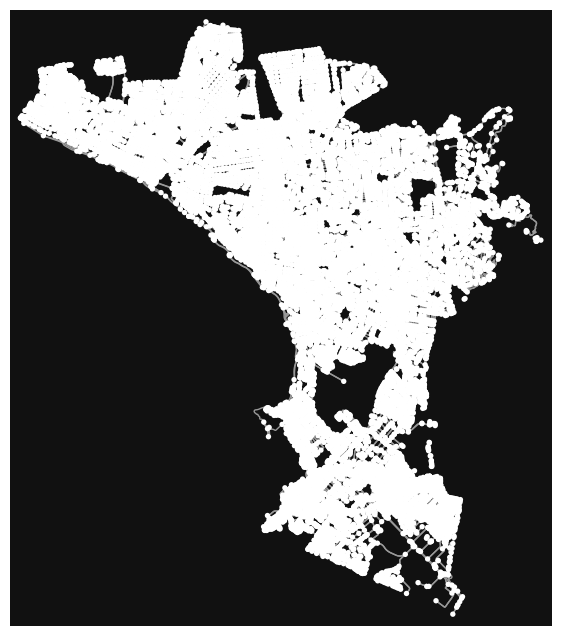

(<Figure size 800x800 with 1 Axes>, <Axes: >)

In [30]:

import heapq
import math
import requests
import csv
import time
import osmnx as ox
import networkx as nx
import matplotlib.pyplot as plt
from shapely.geometry import Point
from geopy.geocoders import Nominatim
from datetime import datetime


# Descargar los límites (Lima Moderna)
lima_moderna_places = ['San Miguel, Lima, Peru',
                        'Magdalena del Mar, Lima, Peru', 
                        'Pueblo Libre, Lima, Peru',
                        'Miraflores, Lima, Peru', 
                        'San Isidro, Lima, Peru', 
                        'Jesus Maria, Lima, Peru', 
                        'Breña, Lima, Peru',
                        'Lince, Lima, Peru', 
                        'Barranco, Lima, Peru',
                        'San Borja, Lima, Peru', 
                        'Santiago de Surco, Lima, Peru',
                        'La Victoria, Lima, Peru',
                        'Chorrillos, Lima, Peru',
                        'Surquillo, Lima, Peru',
                        ]

lima_moderna_boundaries = ox.geocode_to_gdf(lima_moderna_places)

G_lima = ox.graph_from_place('Lima Metropolitana, Peru', network_type='drive')

def remove_nodes_outside_boundaries(G, boundaries_gdf):
    nodes_to_remove = []
    for node, data in G.nodes(data=True):
        point = Point(data['x'], data['y'])  
        if not boundaries_gdf.geometry.contains(point).any():  
            nodes_to_remove.append(node)

    G.remove_nodes_from(nodes_to_remove)  

remove_nodes_outside_boundaries(G_lima, lima_moderna_boundaries)

ox.plot_graph(G_lima)

In [31]:
print(len(G_lima.nodes))

18521


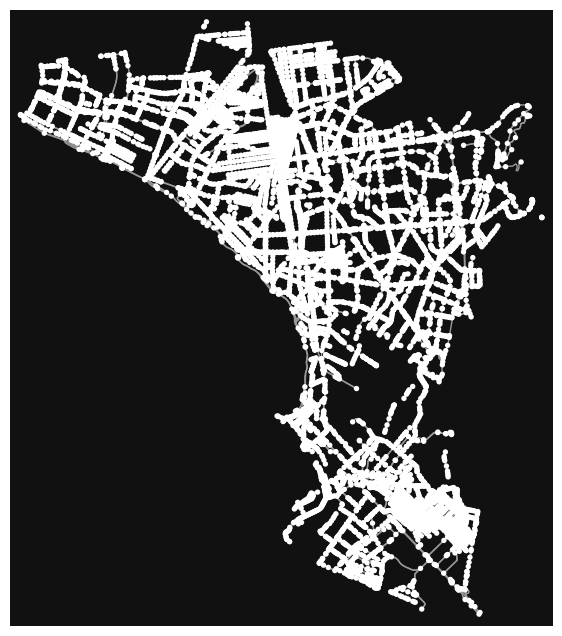

(<Figure size 800x800 with 1 Axes>, <Axes: >)

In [34]:
custom_road_types = [
    'avenue','avenida', 'carretera', 'boulevard', 'motorway', 'trunk', 'primary',
    'prolongación','vía','ovalo','circuito','bajada' ,'subida','quebrada',
    'plaza','malecón'
]

def filter_custom_roads(G, road_types):
    """
    Filters the graph to keep only specified road types.
    """
    edges_to_keep = []
    
    for u, v, k, d in G.edges(keys=True, data=True):
        # Check if 'highway' exists and matches road types
        highway_match = 'highway' in d and any(road_type in d['highway'] for road_type in road_types)
        
        # Check if 'name' exists, is a string, and matches road types
        name_match = 'name' in d and isinstance(d['name'], str) and any(road_type in d['name'].lower() for road_type in road_types)
        
        # Keep edges that match either condition
        if highway_match or name_match:
            edges_to_keep.append((u, v, k))
    
    return G.edge_subgraph(edges_to_keep).copy()

G_lima = filter_custom_roads(G_lima, custom_road_types)

ox.plot_graph(G_lima)

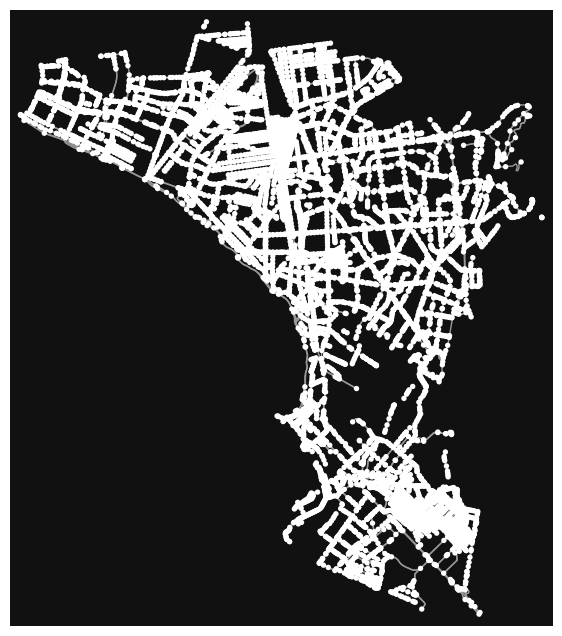

(<Figure size 800x800 with 1 Axes>, <Axes: >)

In [35]:
# Guardar el grafo
ox.save_graphml(G_lima, filepath='lima_moderna2.graphml')

# Más tarde, cargar el grafo
G_lima = ox.load_graphml('lima_moderna2.graphml')

# Ahora puedes trabajar con G_loaded
ox.plot_graph(G_lima)

In [36]:
G = G_lima

In [37]:
print(len(G.nodes))

9410


In [38]:
def get_coordinates(location):
    geolocator = Nominatim(user_agent="geoapi_Exercises")
    location = geolocator.geocode(location)
    return (location.latitude, location.longitude)


upcSanIsidro_coords = get_coordinates("UPC San Miguel, Lima, Peru")
upcSanMiguel_coords = get_coordinates("UPC San Isidro, Lima, Peru")

print("Coordenadas de UPC San Isidro:", upcSanIsidro_coords)
print("Coordenadas de UPC San Miguel:", upcSanMiguel_coords)

Coordenadas de UPC San Isidro: (-12.076417849999999, -77.09360323404653)
Coordenadas de UPC San Miguel: (-12.08753645, -77.04999171754437)


In [39]:
upcSanIsidro_node = ox.distance.nearest_nodes(G, upcSanIsidro_coords[1], upcSanIsidro_coords[0])
upcSanMiguel_node = ox.distance.nearest_nodes(G, upcSanMiguel_coords[1], upcSanMiguel_coords[0])
print("Nodo de UPC San Isidro:", upcSanIsidro_node)
print("Nodo de UPC San Miguel:", upcSanMiguel_node)

Nodo de UPC San Isidro: 10691273528
Nodo de UPC San Miguel: 263390005


In [40]:
def haversine(lon1,lat1, lon2,lat2):
    R = 6371  # ratio of earth in km
    phi1 = math.radians(lat1)
    phi2 = math.radians(lat2)
    delta_phi = math.radians(lat2 - lat1)
    delta_lambda = math.radians(lon2 - lon1)

    a = math.sin(delta_phi / 2) ** 2 + math.cos(phi1) * math.cos(phi2) * math.sin(delta_lambda / 2) ** 2
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1 - a))

    distance = R * c
    return distance

def heuristic(node1, node2, G):
    x1, y1 = G.nodes[node1]['x'], G.nodes[node1]['y']
    x2, y2 = G.nodes[node2]['x'], G.nodes[node2]['y']
    return haversine(x1,y1, x2,y2)

def astar(G, start, goal):
    open_list = []
    heapq.heappush(open_list, (0, start))
    
    came_from = {}
    g_costs = {start: 0}
    f_costs = {start: heuristic(start, goal, G)}
    seti = {}
    unique = []
    
    path = []
    while open_list:
        # Obtener el nodo con menor costo f (g + h)
        current = heapq.heappop(open_list)[1]
        
        if current == goal:
            while current in came_from:
                path.append(current)
                current = came_from[current]
            path.append(start)
        
        for neighbor in G.neighbors(current):
            if (current, neighbor) not in seti: 
                seti[(current, neighbor)] = 1
                unique.append((current, neighbor))
            
            tentative_g_cost = g_costs[current] + heuristic(current, neighbor, G)
            
            if neighbor not in g_costs or tentative_g_cost < g_costs[neighbor]:
                came_from[neighbor] = current
                g_costs[neighbor] = tentative_g_cost
                f_costs[neighbor] = tentative_g_cost
                heapq.heappush(open_list, (f_costs[neighbor], neighbor))
        
    return path[::-1], g_costs[goal], unique


start_node = upcSanIsidro_node
goal_node = upcSanMiguel_node


path, cost, uniqueEdges = astar(G,start_node, goal_node)

if path:
    print(f"Camino encontrado: {path}")
else:
    print("No se encontró un camino.")

print(f"Numero de conexiones totales acumuladas: {len(uniqueEdges)}")
print(f"Conexiones Unicas: {uniqueEdges}")
route_length = sum(heuristic(path[i], path[i+1], G) for i in range(len(path) - 1))
print(f"Distancia desde la UPC San Isidro al de San Miguel utilizando A*: {route_length:.2f} km")                                                                                                                                                                                                                                                                                                           

Camino encontrado: [10691273528, 592287606, 1181353069, 592287414, 589643132, 331597623, 331597619, 607234709, 4347476109, 4347476110, 593898417, 4041852033, 1181353062, 593898351, 589642708, 589642691, 462973799, 331597615, 331597613, 331597611, 331597610, 611484239, 4343393904, 649998852, 606937338, 606937350, 606182713, 605674307, 639108350, 639091478, 605674221, 10005231076, 316809684, 316810074, 606182739, 606182740, 331597605, 606182747, 263384497, 3854554751, 5433888564, 263384499, 263384500, 263384501, 4347757183, 263384502, 10313727030, 10313727029, 263384694, 263384506, 263384507, 263384563, 2793008248, 6302866756, 4042421393, 5072692010, 2793008249, 263109777, 263109778, 263109782, 4578581771, 2209660424, 263109786, 263110816, 2840596721, 4578585832, 263390005]
Numero de conexiones totales acumuladas: 11863
Conexiones Unicas: [(10691273528, 746787329), (10691273528, 592287606), (746787329, 10691273528), (746787329, 746787330), (746787329, 1273487046), (592287606, 1181353069)

In [56]:
# def writeHeaders():
#     headers = ['Dia', 'Hora', 'Latitud Central', 'Longitud Central', 'Tipo de Via', 'Congestion']
#     with open('data.csv', mode='w', newline='') as file:
#         writer = csv.DictWriter(file, fieldnames=headers)
#         writer.writeheader()

# writeHeaders()

In [60]:
from collections import Counter

def defineCoordsCentrals(uniqueEdges):
    coordinates = []

    for node1, node2 in uniqueEdges:
        x1, y1 = transformNodeToCoordenates(node1)
        #Longitud y Latitud
        x2, y2 = transformNodeToCoordenates(node2) 
        coordinates.append(((y1+y2)/2, (x1+x2)/2))  # Coord Central
    return coordinates

def transformNodeToCoordenates(node):
    return (G.nodes[node]['x'], G.nodes[node]['y'])


def defineRoadType(latitude, longitude):
    geolocator = Nominatim(user_agent="my_geocoder_app3")
    try:
        location = geolocator.reverse(f"{latitude}, {longitude}")
    except Exception:
        geolocator = Nominatim(user_agent=f"my_geocoder_app3{int(time.time())}")
        location = geolocator.reverse(f"{latitude}, {longitude}")
    
    if location:
        address = location.raw['address']
        
        road_type_keys = {
            'road', 'highway', 'route', 'street', 'lane', 'avenue', 'boulevard',
            'living_street', 'residential', 'avenue','avenida', 'carretera', 'boulevard', 'motorway', 'trunk', 'primary',
            'prolongación','vía','ovalo','circuito','bajada' ,'subida','quebrada',
            'plaza','malecón'
        }
        
        road_type = next((address.get(key) for key in road_type_keys if key in address), None)
        print(road_type)
        
        return road_type
    else:
        return "Could not obtain information for these coordinates."

def defineCongestion(coords1, coords2):
    access_token = get_env_variable('API_KEY_MPBOX')
    
    coordinates = f"{coords1[0]},{coords1[1]};{coords2[0]},{coords2[1]}"  # "long1,lat1;long2,lat2"
    
    directions_url = f"https://api.mapbox.com/directions/v5/mapbox/driving-traffic/{coordinates}"
    
    directions_params = {
        "access_token": access_token,
        "alternatives": "false",
        "geometries": "geojson",
        "overview": "full",
        "annotations": "congestion"
    }

    response = requests.get(directions_url, params=directions_params)
    if response.status_code == 200:
        directions = response.json()
        congestion_levels = directions['routes'][0]['legs'][0]['annotation']['congestion']
        return Counter(congestion_levels).most_common(1)[0][0] #valor mas frecuente
    else:
        raise Exception(f"Directions API error: {response.status_code}")

def saveSingleExample(dia, hora, latcentral, loncentral, tipo_via, congestion):
    with open('data.csv', mode='a+', newline='') as file:
        writer = csv.writer(file)
        writer.writerow([dia, hora, latcentral, loncentral, tipo_via, congestion])


def defineDayHour():
    now = datetime.now()
    dia = now.strftime("%A")  # Día de la semana
    hora = now.strftime("%H:%M")  # Hora en formato HH:MM
    return dia, hora


coordinatesCentrals = defineCoordsCentrals(uniqueEdges)


#UniqueEdges son mis conexiones unicas (node1, node2)
#Las coordenadas centrales se calculan a partir de estas dos de aqui, ya convertidas a coordenadas
i = 0
getCongestion = {}
getCongestion_Edge = {}
for y,x in coordinatesCentrals:
    day, hour = defineDayHour()
    roadType = defineRoadType(y, x)
    node1, node2 = uniqueEdges[i]
    congestion = defineCongestion(transformNodeToCoordenates(node1), transformNodeToCoordenates(node2))
    getCongestion[node1] = congestion
    getCongestion[node2] = congestion
    getCongestion_Edge[(node1,node2)] = congestion
    i+=1
    saveSingleExample(day, hour, y, x, roadType, congestion)

print(coordinatesCentrals)
print("Datos guardados en CSV.")


Avenida Luis Banchero Rossi
Avenida Rafael Escardó
Avenida Luis Banchero Rossi
Avenida Luis Banchero Rossi
Avenida Rafael Escardó
Avenida Rafael Escardó
Avenida La Marina
Avenida Rafael Escardó
Avenida de La Marina
Avenida de La Marina
Avenida de La Marina
Avenida de La Marina
Avenida Rafael Escardó
Avenida de La Marina
Avenida Rafael Escardó
Avenida de La Marina
Avenida de La Marina
Avenida Rafael Escardó
Avenida Luis Banchero Rossi
Avenida Luis Banchero Rossi
Avenida de La Marina
Avenida de La Marina
Avenida Rafael Escardó
Avenida Rafael Escardó
Avenida de La Marina
Avenida Rafael Escardó
Avenida Rafael Escardó
Avenida Luis Banchero Rossi
Avenida Luis Banchero Rossi
Avenida Rafael Escardó
Avenida Carlos Gonzalez
Avenida Rafael Escardó
Avenida Rafael Escardó
Avenida Luis Banchero Rossi
Avenida Luis Banchero Rossi
Avenida de La Marina
Avenida Los Patriotas
Avenida Rafael Escardó
Avenida Rafael Escardó
Avenida Rafael Escardó
Avenida Rafael Escardó
Avenida Luis Banchero Rossi
Avenida Raf

In [61]:
# Aproximar los nodos más cercanos a las coordenadas al grafo de Lima
nodes = [ox.distance.nearest_nodes(G, coord[0], coord[1]) for coord in coordinatesCentrals]

print(len(nodes))

11863


In [ ]:
# import requests
# import csv
# import time
# from datetime import datetime, timedelta
# import random



# # Lista de puntos de interés en Lima (amplía esta lista según tus necesidades)
# lima_points = [
#     "Plaza de Armas de Lima",
#     "Miraflores",
#     "San Isidro",
#     "Aeropuerto Jorge Chávez",
#     "Jockey Plaza",
#     "UPC Monterrico",
#     "Estadio Nacional del Perú",
#     "Parque de las Leyendas",
#     "Centro Comercial Larcomar",
#     "Puente de los Suspiros"
# ]

# # Convertir direcciones a coordenadas
# lima_coordinates = {}
# for point in lima_points:
#     try:
#         lima_coordinates[point] =  0#get_coordinates_from_address(f"{point}, Lima, Peru")
#         time.sleep(1)  # Para respetar los límites de la API
#     except Exception as e:
#         print(f"Error obteniendo coordenadas para {point}: {e}")

# # Función para recopilar datos
# def collect_traffic_data(output_file):
#         start_time = datetime.now()
#         end_time = start_time + timedelta(days=7)  # Recopilar datos durante 24 horas

#         while datetime.now() < end_time:
#             for origin in lima_coordinates:
#                 for destination in lima_coordinates:
#                     if origin != destination:
#                         try:
                            
#                             time.sleep(2)  # Para respetar los límites de la API
#                         except Exception as e:
#                             print(f"Error recopilando datos para {origin} a {destination}: {e}")
            
#             # Esperar antes de la siguiente ronda de recopilación
#             time.sleep(90)  # 1.5 minutos

# # Ejecutar la recopilación de datos
# collect_traffic_data('lima_traffic_data.csv')

## USANDO MAPBOX

In [44]:
# # Imprimir posiciones de los nodos para verificar que todos tienen 'x' y 'y'
# for node in nodes:
#     if 'x' in G.nodes[node] and 'y' in G.nodes[node]:
#         print(f"Nodo {node}: ({G.nodes[node]['x']}, {G.nodes[node]['y']})")
#     else:
#         print(f"Nodo {node} no tiene coordenadas.")


Nodo 4054805268: (-76.9628072, -12.1032225)
Nodo 4054805276: (-76.9624903, -12.1031969)
Nodo 4054805276: (-76.9624903, -12.1031969)
Nodo 4054805276: (-76.9624903, -12.1031969)
Nodo 4054805276: (-76.9624903, -12.1031969)
Nodo 4054805276: (-76.9624903, -12.1031969)
Nodo 4054805276: (-76.9624903, -12.1031969)
Nodo 4054805276: (-76.9624903, -12.1031969)
Nodo 4054805276: (-76.9624903, -12.1031969)
Nodo 4054805276: (-76.9624903, -12.1031969)
Nodo 4054805276: (-76.9624903, -12.1031969)
Nodo 4054805276: (-76.9624903, -12.1031969)
Nodo 4054805276: (-76.9624903, -12.1031969)
Nodo 4054805276: (-76.9624903, -12.1031969)
Nodo 393864453: (-76.9626337, -12.102967)
Nodo 393864453: (-76.9626337, -12.102967)
Nodo 3787830258: (-76.9628289, -12.1027457)
Nodo 3787830258: (-76.9628289, -12.1027457)
Nodo 3787830258: (-76.9628289, -12.1027457)
Nodo 3787830258: (-76.9628289, -12.1027457)
Nodo 3787830258: (-76.9628289, -12.1027457)
Nodo 3787830259: (-76.9629925, -12.1027997)
Nodo 3787830259: (-76.9629925, -12.1

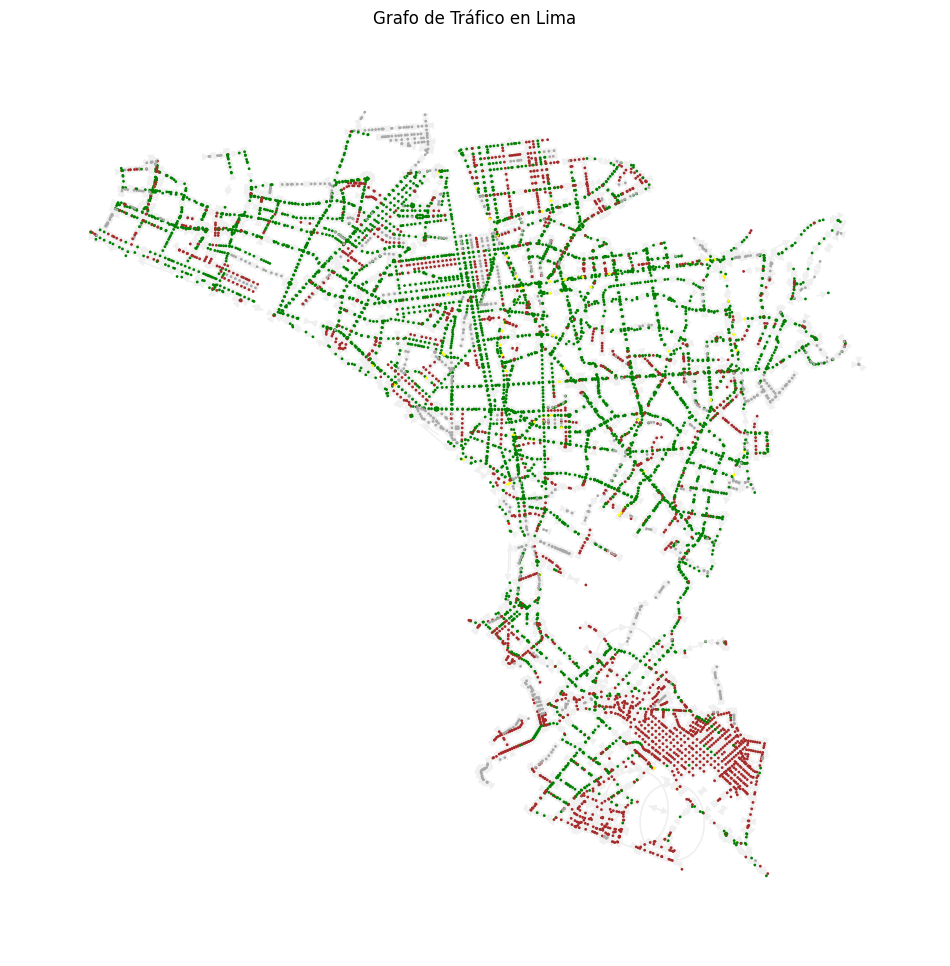

In [62]:
congestionTocolor = {
    'unknown': 'brown',
    'low': 'green',
    'moderate': 'yellow',
    'heavy': 'red',
    'severe': 'purple'
}


edge_colors = []
edge_widths = []

for edge in G.edges:
    if edge in getCongestion_Edge: 
        congestion_level = getCongestion_Edge[edge]
        edge_colors.append(congestionTocolor.get(congestion_level, '#800080'))
        edge_widths.append(3) 
    else:
        edge_colors.append('#f0f0f0')  
        edge_widths.append(1)  

pos = {node: (G.nodes[node]['x'], G.nodes[node]['y']) for node in G.nodes}

node_colors = []
for node in G.nodes():
    if node in getCongestion:
        congestion_level = getCongestion[node]
        node_colors.append(congestionTocolor[congestion_level])
    else:
        node_colors.append('#A9A9A9')

plt.figure(figsize=(12, 12))  

nx.draw_networkx_nodes(G, pos, node_color=node_colors, node_size=1)

nx.draw_networkx_edges(G, pos, edge_color=edge_colors,  alpha=1, width= edge_widths)

plt.title('Grafo de Tráfico en Lima')
plt.axis('off')
plt.show()